# =====================================
# Forest Cover Type Classification 
# Author: Syed Huzaifa Bin Khamis
# Internship: Elevvo Pathways (Cairo, Egypt)
# =====================================

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import compute_class_weight

In [7]:
# -------------------------------
# 1) Load the Covertype dataset
# Using sklearn's fetch_covtype (downloads automatically if missing).
# This returns data, target, and feature names. (54 features, 7 classes).
# Source references: UCI Covertype & sklearn fetch_covtype docs.
# :contentReference[oaicite:1]{index=1}
# -------------------------------
cov = fetch_covtype(as_frame=True)   # returns a Bunch with .data, .target, .feature_names
X = cov.data.copy()
y = cov.target.copy()   # values 1..7

print("Shape X:", X.shape, "Shape y:", y.shape)
print("Feature sample:", list(X.columns[:10]))
print("Unique classes:", np.unique(y))

# quick class distribution
print("\nClass distribution:")
print(y.value_counts().sort_index())

Shape X: (581012, 54) Shape y: (581012,)
Feature sample: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Unique classes: [1 2 3 4 5 6 7]

Class distribution:
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64



Continuous features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


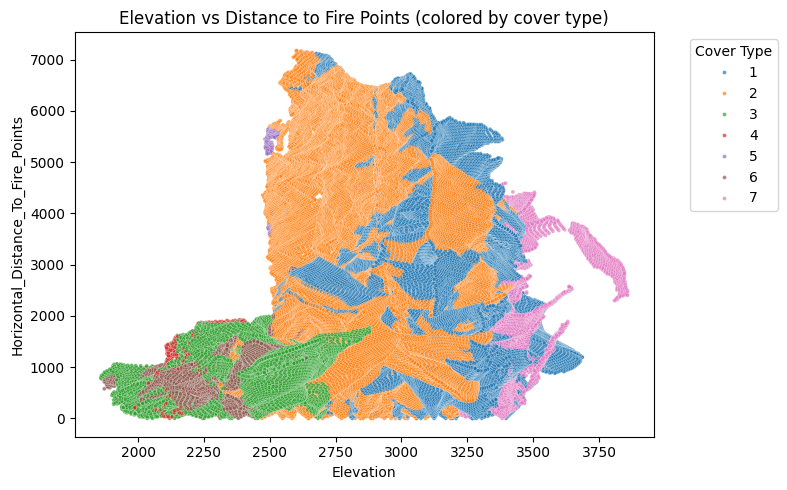

In [8]:
# -------------------------------
# 2) Basic EDA & preprocessing notes
# - Continuous features are already numeric.
# - Wilderness area and soil type are already one-hot binary features.
# - Tree-based models (RF, XGBoost) don't require scaling, but I include a scaler only for pipelines if needed.
# -------------------------------
# Show summary statistics for continuous features (first 10 features are continuous)
cont_features = cov.feature_names[:10]  # from fetch_covtype docs: first 10 are continuous
print("\nContinuous features:", cont_features)
display(X[cont_features].describe().T)

# Optional visualization: 2D scatter of Elevation vs Horizontal_Distance_To_Fire_Points colored by cover type
plt.figure(figsize=(8,5))
sns.scatterplot(x=X['Elevation'], y=X['Horizontal_Distance_To_Fire_Points'], hue=y, palette='tab10', s=8, alpha=0.7)
plt.title('Elevation vs Distance to Fire Points (colored by cover type)')
plt.legend(title='Cover Type', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
# -------------------------------
# 3) Train/test split (stratified because of class imbalance)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (464809, 54) Test size: (116203, 54)


In [10]:
# -------------------------------
# 4) Class weighting (optional): compute balanced class weights to help imbalance
# -------------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}
print("Computed class weights:", class_weight_dict)

Computed class weights: {np.int32(1): np.float64(0.39181272253992233), np.int32(2): np.float64(0.29298131712974634), np.int32(3): np.float64(2.3214797648598298), np.int32(4): np.float64(30.209866112049916), np.int32(5): np.float64(8.743914368486399), np.int32(6): np.float64(4.779133850171708), np.int32(7): np.float64(4.046884794873581)}


In [11]:
# -------------------------------
# 5) Baseline model: Random Forest (default) - quick fit
# -------------------------------
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')
t0 = time.time()
rf.fit(X_train, y_train)
t_rf = time.time() - t0
print(f"\nRandom Forest trained in {t_rf:.1f}s")

In [ ]:
# Evaluate
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", acc_rf)
print("Random Forest Balanced Accuracy:", bal_acc_rf)
print("\nClassification report (RF):")
print(classification_report(y_test, y_pred_rf, digits=4))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.show()

In [ ]:
# Feature importance (RF)
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 feature importances (Random Forest):")
display(fi.head(15))

plt.figure(figsize=(8,5))
fi.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to 0-based values
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42,
    tree_method='hist'
)

t0 = time.time()
xgb.fit(X_train, y_train)
t_xgb = time.time() - t0
print(f"\nXGBoost trained in {t_xgb:.1f}s")

y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Accuracy:", acc_xgb)
print("XGBoost Balanced Accuracy:", bal_acc_xgb)
print("\nClassification report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, digits=4))


In [ ]:
# Confusion matrix XGBoost
cm2 = confusion_matrix(y_test, y_pred_xgb, labels=classes)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,6))
disp2.plot(ax=ax, cmap='Oranges', colorbar=False)
plt.title("XGBoost - Confusion Matrix")
plt.show()

In [ ]:
# Feature importance (XGBoost)
# XGBoost has .feature_importances_
fi_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 feature importances (XGBoost):")
display(fi_xgb.head(15))

plt.figure(figsize=(8,5))
fi_xgb.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.show()

In [ ]:
# -------------------------------
# 7) Bonus: Hyperparameter Tuning (RandomizedSearchCV)
# We'll tune RandomForest and XGBoost with small search spaces to save time.
# NOTE: This can be time-consuming. Use n_iter small (e.g. 20) for demo.
# -------------------------------
from scipy.stats import randint, uniform

# Random Forest Randomized Search
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(8, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),
    'max_features': ['sqrt', 'log2', 0.3, 0.5, None]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV for RandomForest (this may take several minutes)...")
t0 = time.time()
rf_search.fit(X_train, y_train)
t_search_rf = time.time() - t0
print(f"RandomForest RandomizedSearchCV done in {t_search_rf/60:.1f} minutes")
print("Best RF params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_

In [ ]:
# Evaluate best_rf
y_pred_best_rf = best_rf.predict(X_test)
print("\nBest RF Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf, digits=4))

In [ ]:
# XGBoost Randomized Search
xgb_param_dist = {
    'n_estimators': randint(100, 800),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', num_class=7, eval_metric='mlogloss', use_label_encoder=False, random_state=42, n_jobs=-1, tree_method='hist'),
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV for XGBoost (this may take several minutes)...")
t0 = time.time()
xgb_search.fit(X_train, y_train)
t_search_xgb = time.time() - t0
print(f"XGBoost RandomizedSearchCV done in {t_search_xgb/60:.1f} minutes")
print("Best XGB params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_

In [ ]:
# Evaluate best_xgb
y_pred_best_xgb = best_xgb.predict(X_test)
print("\nBest XGBoost Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_best_xgb))
print(classification_report(y_test, y_pred_best_xgb, digits=4))

In [ ]:
# -------------------------------
# 8) Save best model (optional)
# -------------------------------
import joblib
joblib.dump(best_xgb, "best_xgb_covtype.pkl")
joblib.dump(best_rf, "best_rf_covtype.pkl")
print("\nSaved best models to disk: best_xgb_covtype.pkl, best_rf_covtype.pkl")